# Continuous Control    (Actor-Critic Reinforcement Learning)

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from  collections  import deque
from itertools import count
import torch
import time
from ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline
env_info = env.reset(train_mode=True)[brain_name]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=8)

In [6]:
def ddpg(n_episodes=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores_global = []
        
    time_start = time.time()
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        score_average = 0

        for timestep in range(2000):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, timestep)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)    
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        
        print('Episode: {}, Score: {:.2f}, Max: {:.2f}, Min: {:.2f} '\
              .format(i_episode, score, np.max(scores), np.min(scores)))
        
        if i_episode % print_every == 0 or (len(scores_deque) == 100 and np.mean(scores_deque) >= 30) :
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            s = (int)(time.time() - time_start) 
            print('*** Episode {}\tAverage Score: {:.2f}, Time: {:02}:{:02}:{:02} *** '\
                  .format(i_episode, np.mean(scores_deque), s//3600, s%3600//60, s%60))  
            
        if len(scores_deque) == 100 and np.mean(scores_deque) >= 30:  
            print('Environment solved !')
            break
            
    return scores_global

scores = ddpg()

Episode: 1, Score: 0.71, Max: 2.04, Min: 0.02 
Episode: 2, Score: 0.80, Max: 2.12, Min: 0.10 
Episode: 3, Score: 0.76, Max: 1.59, Min: 0.00 
Episode: 4, Score: 0.72, Max: 1.46, Min: 0.13 
Episode: 5, Score: 1.17, Max: 2.48, Min: 0.26 
Episode: 6, Score: 0.70, Max: 1.75, Min: 0.14 
Episode: 7, Score: 1.12, Max: 2.21, Min: 0.09 
Episode: 8, Score: 1.13, Max: 2.09, Min: 0.15 
Episode: 9, Score: 1.26, Max: 2.90, Min: 0.00 
Episode: 10, Score: 1.09, Max: 2.44, Min: 0.13 
*** Episode 10	Average Score: 0.95, Time: 00:02:42 *** 
Episode: 11, Score: 1.88, Max: 3.97, Min: 0.31 
Episode: 12, Score: 1.51, Max: 2.79, Min: 0.18 
Episode: 13, Score: 1.51, Max: 3.66, Min: 0.21 
Episode: 14, Score: 1.43, Max: 2.62, Min: 0.39 
Episode: 15, Score: 1.78, Max: 3.42, Min: 0.75 
Episode: 16, Score: 1.93, Max: 3.17, Min: 0.90 
Episode: 17, Score: 1.90, Max: 3.69, Min: 0.73 
Episode: 18, Score: 1.97, Max: 4.75, Min: 0.45 
Episode: 19, Score: 1.95, Max: 4.05, Min: 0.16 
Episode: 20, Score: 1.91, Max: 4.26, Min:

Episode: 150, Score: 31.09, Max: 36.01, Min: 20.85 
*** Episode 150	Average Score: 18.56, Time: 00:53:50 *** 
Episode: 151, Score: 30.04, Max: 35.32, Min: 22.66 
Episode: 152, Score: 32.84, Max: 36.18, Min: 25.95 
Episode: 153, Score: 32.63, Max: 36.52, Min: 24.48 
Episode: 154, Score: 35.48, Max: 39.50, Min: 25.82 
Episode: 155, Score: 34.71, Max: 38.77, Min: 29.35 
Episode: 156, Score: 34.20, Max: 39.17, Min: 27.48 
Episode: 157, Score: 36.20, Max: 39.27, Min: 22.97 
Episode: 158, Score: 36.65, Max: 39.30, Min: 33.21 
Episode: 159, Score: 35.61, Max: 38.84, Min: 27.36 
Episode: 160, Score: 35.07, Max: 39.04, Min: 28.34 
*** Episode 160	Average Score: 21.22, Time: 00:57:38 *** 
Episode: 161, Score: 36.24, Max: 39.57, Min: 29.96 
Episode: 162, Score: 35.79, Max: 39.55, Min: 29.40 
Episode: 163, Score: 36.97, Max: 39.54, Min: 29.14 
Episode: 164, Score: 35.53, Max: 39.65, Min: 21.76 
Episode: 165, Score: 35.76, Max: 39.02, Min: 27.52 
Episode: 166, Score: 37.04, Max: 39.62, Min: 31.07 


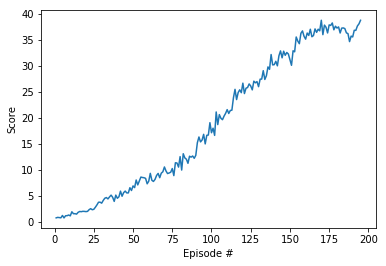

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
env.close()